# CS445: Computational Photography
## Programming Project 4: Image-Based Lighting


## Recovering HDR Radiance Maps 

Load libraries and data

In [35]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [572]:
# System imports
from os import path
import math

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import os

# modify to where you store your project data including utils
#datadir = "/content/drive/My Drive/cs445_projects/proj4/" 
datadir = "/Users/pranav/Desktop/CS445/proj4"


utilfn = datadir + "utils"
!cp -r "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .

# can change this to your output directory of choice
!mkdir "images"
!mkdir "images/outputs"

# import starter code
import utils
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter



cp: /Users/pranav/Desktop/CS445/proj4utils: No such file or directory
cp: /Users/pranav/Desktop/CS445/proj4samples: No such file or directory
mkdir: images: File exists
mkdir: images/outputs: File exists


### Reading LDR images

You can use the provided samples or your own images.  You get more points for using your own images, but it might help to get things working first with the provided samples.

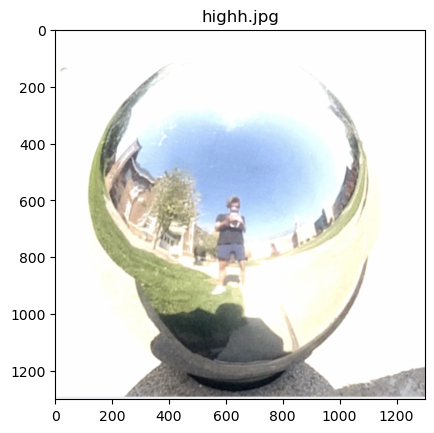

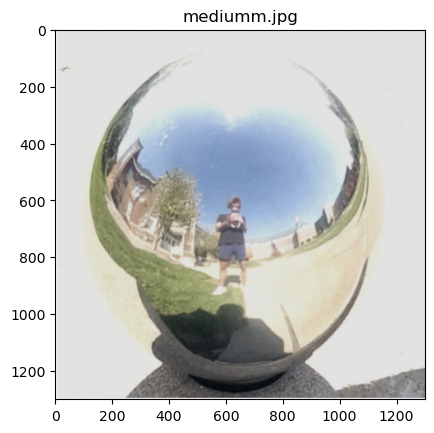

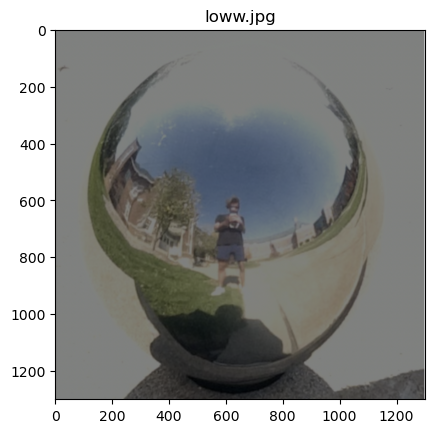

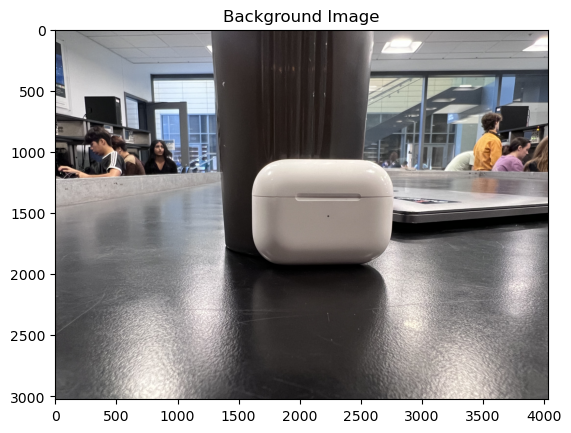

In [573]:
# TODO: Replace this with your path and files
imdir = 'samples'
imfns = ['highh.jpg', 'mediumm.jpg', 'loww.jpg']
exposure_times = [1/24.0, 1/60.0, 1/120.0]

ldr_images = []
for f in np.arange(len(imfns)):
    im = read_image(imdir + '/' + imfns[f])
    if f == 0:
        imsize = int((im.shape[0] + im.shape[1]) / 2)  # set width/height of ball images
        ldr_images = np.zeros((len(imfns), imsize, imsize, 3))
    ldr_images[f] = cv2.resize(im, (imsize, imsize))

# Plot the LDR images
for i in range(len(imfns)):
    plt.figure(imfns[i])
    plt.imshow(ldr_images[i])
    plt.title(imfns[i])

# Plot the background image
background_image_file = imdir + '/' + 'BACKGROUND.jpeg'
background_image = read_image(background_image_file)
plt.figure("Background")
plt.imshow(background_image)
plt.title("Background Image")

plt.show()

### Naive LDR merging 

Compute the HDR image as average of irradiance estimates from LDR images

In [574]:
def make_hdr_naive(ldr_images: np.ndarray, exposures: list) -> (np.ndarray, np.ndarray):

    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposures)

    # ldr_images = ldr_images * 255
    irradiance = []
    for i in range(0, N):
        irradiance.append(ldr_images[i]/exposures[i])

    irradiance = np.array(irradiance)
    log_irradiances = np.log(irradiance)
    hdr_image = np.average(irradiance, axis = 0)

    return hdr_image, log_irradiances

In [575]:
def display_hdr_image(im_hdr):
    img = np.nan_to_num(im_hdr, 0)
    img = img.copy().astype(np.float32)

    tonemap1 = cv2.createTonemap(gamma=3)
    res_debvec = tonemap1.process(img)
    res_debvec_8bit = np.clip(res_debvec*255, 0, 255).astype('uint8')
    plt.figure()
    plt.imshow(res_debvec_8bit)

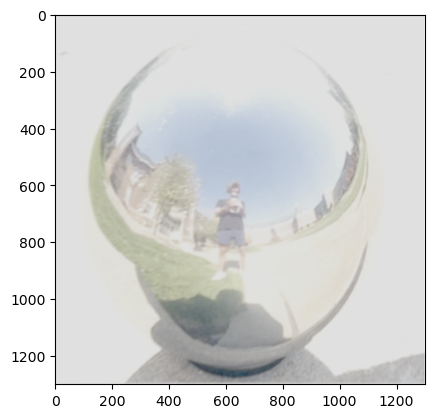

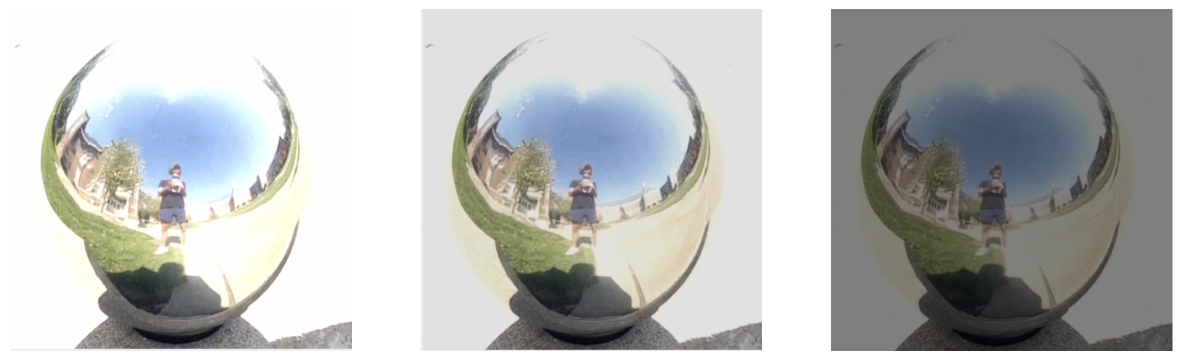

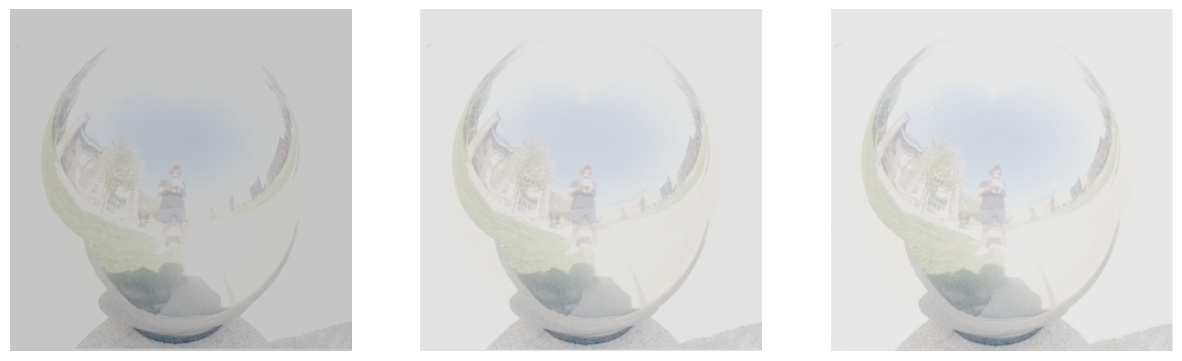

In [576]:
# get HDR image, log irradiance
naive_hdr_image, naive_log_irradiances = make_hdr_naive(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(naive_hdr_image, 'images/outputs/naive_hdr.hdr')

# display HDR image
display_hdr_image(naive_hdr_image)

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(naive_log_irradiances)

### Weighted LDR merging 

Compute HDR image as a weighted average of irradiance estimates from LDR images, where weight is based on pixel intensity so that very low/high intensities get less weight


In [577]:
def make_hdr_weighted(ldr_images: np.ndarray, exposure_times: list) -> (np.ndarray):
    
    w = lambda z: 128 - np.abs(z - 128)
    
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)
    
    weights = w(ldr_images*255)
    irradiance = []

    irradiance = [weights[i] * ldr_images[i] / exposure_times[i] for i in range(N)]
    irradiance = np.array(irradiance)
    adjusted_irradiance = irradiance + 0.01
    normalized_weights = np.sum(weights, axis=0)
    log_irradiances = np.log(adjusted_irradiance / normalized_weights)

    # Compute hdr_image
    weighted_irradiance_sum = np.sum(irradiance, axis=0)
    hdr_image = weighted_irradiance_sum / normalized_weights

    return hdr_image

In [578]:
# get HDR image, log irradiance
weighted_hdr_image = make_hdr_weighted(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(weighted_hdr_image, 'images/outputs/weighted_hdr.hdr')

Display of difference between naive and weighted for your own inspection

Where does the weighting make a big difference increasing or decreasing the irradiance estimate?  Think about why.

Min ratio =  0.41670947044848794   Max ratio =  2.3767734024623013


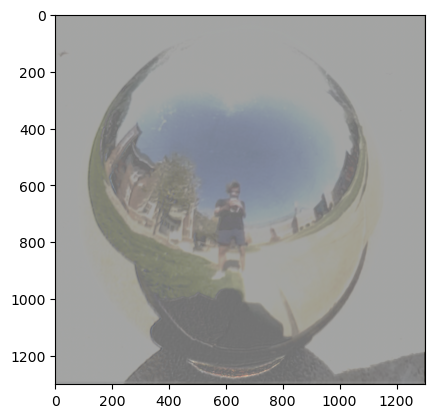

In [579]:
# display difference between naive and weighted 
log_diff_im = np.log(weighted_hdr_image)-np.log(naive_hdr_image)
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

### LDR merging with camera response function estimation 

Compute HDR after calibrating the photometric reponses to obtain more accurate irradiance estimates from each image

Some suggestions on using <tt>gsolve</tt>:
<ul>
	<li>When providing input to gsolve, don't use all available pixels, otherwise you will likely run out of memory / have very slow run times. To overcome, just randomly sample a set of pixels (1000 or so can suffice), but make sure all pixel locations are the same for each exposure.</li>
	<li>The weighting function w should be implemented using Eq. 4 from the paper (this is the same function that can be used for the previous LDR merging method).</li>
	<li>Try different lambda values for recovering <i>g</i>. Try lambda=1 initially, then solve for <i>g</i> and plot it. It should be smooth and continuously increasing. If lambda is too small, g will be bumpy.</li>
	<li>Refer to Eq. 6 in the paper for using g and combining all of your exposures into a final image. Note that this produces log irradiance values, so make sure to exponentiate the result and save irradiance in linear scale.</li>
</ul>

In [580]:
def make_hdr_estimation(ldr_images: np.ndarray, exposure_times: list, lm)-> (np.ndarray, np.ndarray):
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)
    
    # TO DO: implement HDR estimation using gsolve
    # gsolve(Z, B, l, w) -> g, lE
    
    ldr_images = ldr_images*255
        
    random_width = np.random.randint(W, size=1000)
    random_height = np.random.randint(H, size=1000)

    B = np.log(exposure_times)

    wfunction = lambda z: 128 - np.abs(z - 128)
    ind = np.arange(0, 256)
    wvalue = wfunction(ind)


    hdr_image = np.zeros((H,W,C))
    irradiance = np.zeros((N,H,W,C))

    g_values = np.zeros((C, 256))

    for i in range(0, C):
        Z = ldr_images[:, random_height, random_width, i].astype(np.int64)

        g, le = gsolve(Z, B, lm, wvalue)
        g_values[i] = g

        for h in range(H):
            for w in range(W):
                temp = 0
                zvalue_sum = 0
                for n in range(N):
                    z = int(ldr_images[n, h, w, i])
                    temp += wvalue[z]*(g[z]-B[n])
                    zvalue_sum += wvalue[z]
                    irradiance[n, h, w, i] = g[z] - B[n]
                hdr_image[h, w, i] = np.e**(temp/(zvalue_sum))
    return hdr_image, irradiance, g_values

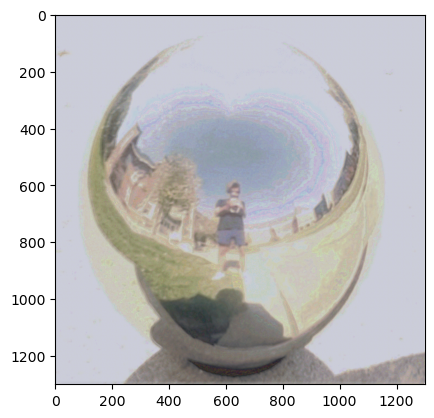

In [581]:
lm = 5
# get HDR 0image, log irradiance
calib_hdr_image, calib_log_irradiances, g = make_hdr_estimation(ldr_images, exposure_times, lm)

# write HDR image to directory
write_hdr_image(calib_hdr_image, 'images/outputs/calib_hdr.hdr')

# display HDR image
display_hdr_image(calib_hdr_image)


The following code displays your results. You can copy the resulting images and plots directly into your report where appropriate.

Min ratio =  0.11888576451981069   Max ratio =  1.768731572151225


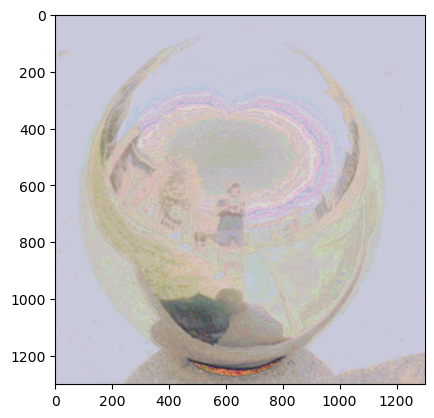

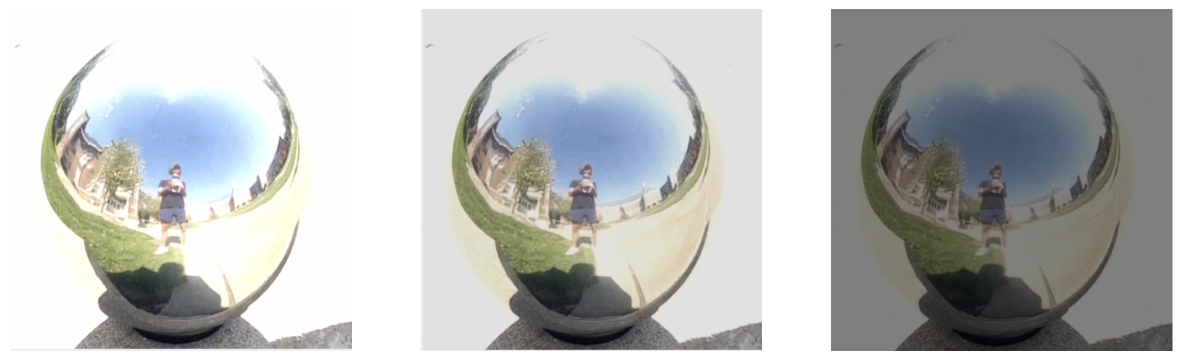

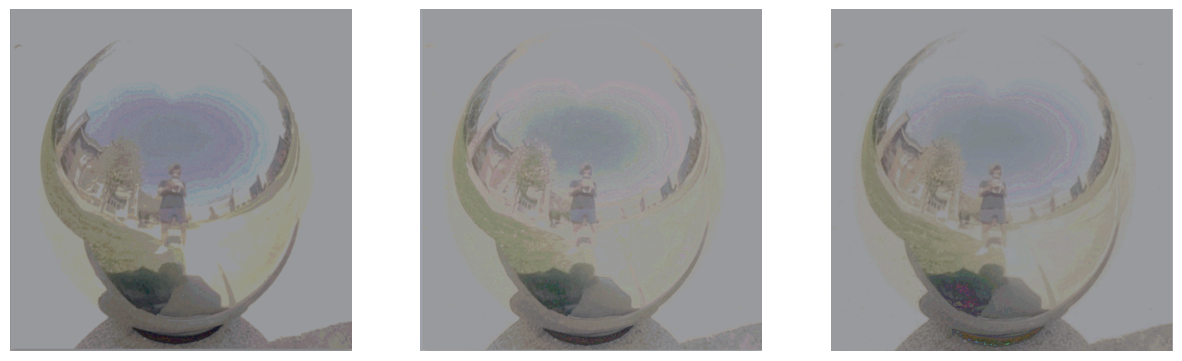

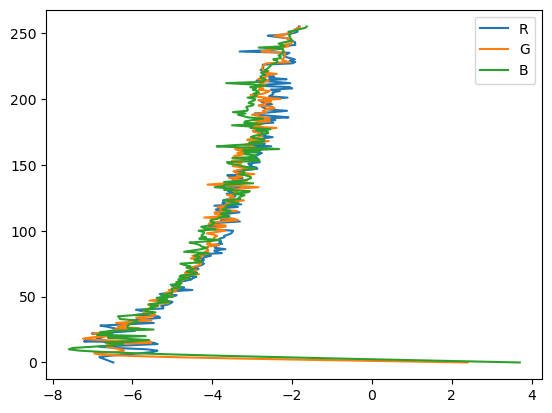

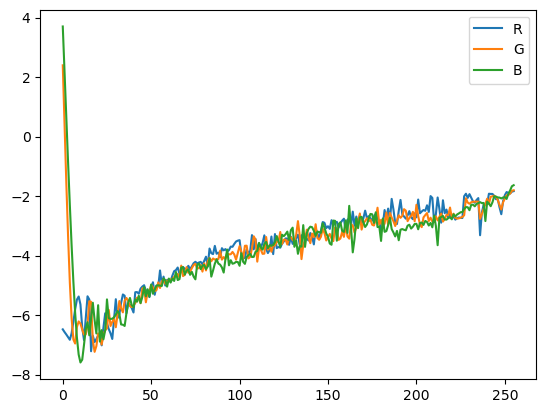

In [582]:
# display difference between calibrated and weighted
log_diff_im = np.log(calib_hdr_image/calib_hdr_image.mean())-np.log(weighted_hdr_image/weighted_hdr_image.mean())
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(calib_log_irradiances)

# plot g vs intensity, and then plot intensity vs g
N, NG = g.shape
labels = ['R', 'G', 'B']
plt.figure()
for n in range(N):
    plt.plot(g[n], range(NG), label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

plt.figure()
for n in range(N):
    plt.plot(range(NG), g[n], label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

naive:  	log range =  4.312 	avg RMS error =  0.336
weighted:	log range =  4.445 	avg RMS error =  0.282
calibrated:	log range =  5.626 	avg RMS error =  0.239


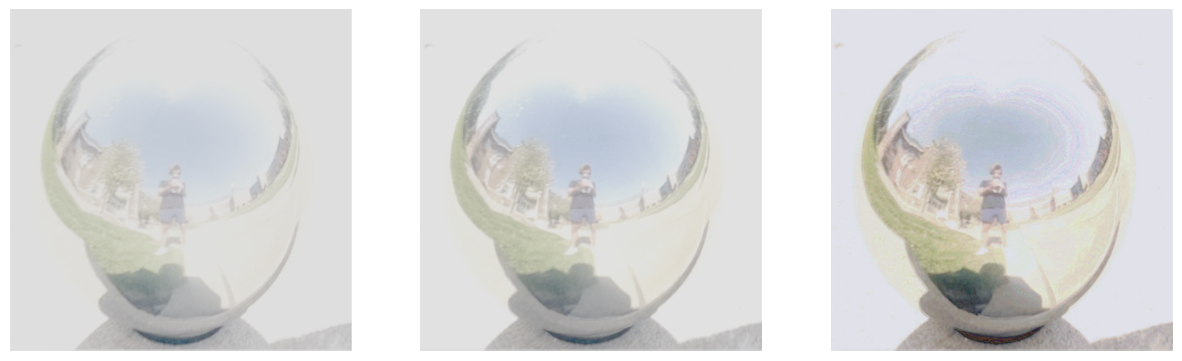

In [583]:
def weighted_log_error(ldr_images, hdr_image, log_irradiances):
  # computes weighted RMS error of log irradiances for each image compared to final log irradiance
  N, H, W, C = ldr_images.shape
  w = 1-abs(ldr_images - 0.5)*2
  err = 0
  for n in np.arange(N):
    err += np.sqrt(np.multiply(w[n], (log_irradiances[n]-np.log(hdr_image))**2).sum()/w[n].sum())/N 
  return err


# compare solutions
err = weighted_log_error(ldr_images, naive_hdr_image, naive_log_irradiances)
print('naive:  \tlog range = ', round(np.log(naive_hdr_image).max() - np.log(naive_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, weighted_hdr_image, naive_log_irradiances)
print('weighted:\tlog range = ', round(np.log(weighted_hdr_image).max() - np.log(weighted_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, calib_hdr_image, calib_log_irradiances)
print('calibrated:\tlog range = ', round(np.log(calib_hdr_image).max() - np.log(calib_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))

# display log hdr images (code provided in utils.display)
display_images_linear_rescale(np.log(np.stack((naive_hdr_image/naive_hdr_image.mean(), weighted_hdr_image/weighted_hdr_image.mean(), calib_hdr_image/calib_hdr_image.mean()), axis=0)))

## Panoramic transformations 

Compute the equirectangular image from the mirrorball image

In [584]:
def panoramic_transform(hdr_image):
    H, W, C = hdr_image.shape
    assert H == W
    assert C == 3

    # TO DO: compute N and R
    nx, ny = np.meshgrid(range(W), range(H))
    nx = (nx-W/2)/(W/2)
    ny = (ny-H/2)/(H/2)
    nz = np.sqrt(1-np.clip(nx**2 + ny**2, a_min=0, a_max=1))
    
    # Normal vector
    N = np.zeros((H,W,3))
    N[:,:,0] = nx
    N[:,:,1] = ny
    N[:,:,2] = nz
    
    # V = (0, 0, -1) for all location within the sphere
    V = np.zeros((H,W,C))
    V[:,:,2] = 1

    R = np.zeros((H,W,3))
    for c in range(C):
        R[:,:,c] = -1 * V[:,:,c]+ 2 * nz * N[:,:,c]

    plt.figure()
    plt.imshow(N)
    plt.figure()
    plt.imshow(R)
    plt.show()
    equirectangular_image = get_equirectangular_image(R, hdr_image) 
    return equirectangular_image.astype(np.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


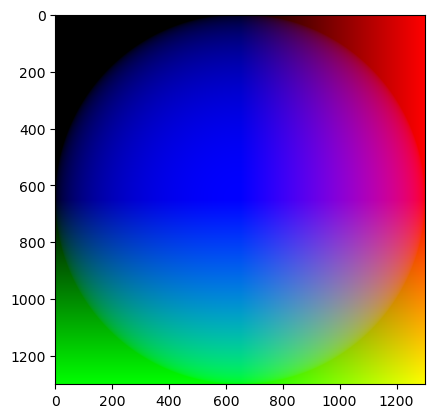

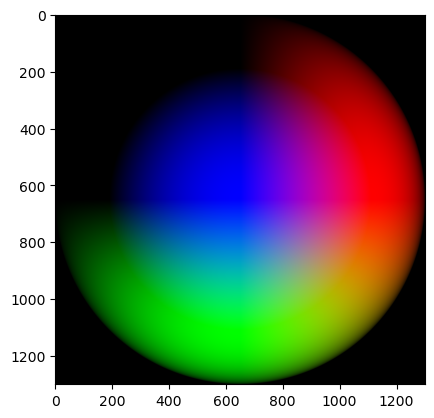

<Figure size 1500x1500 with 0 Axes>

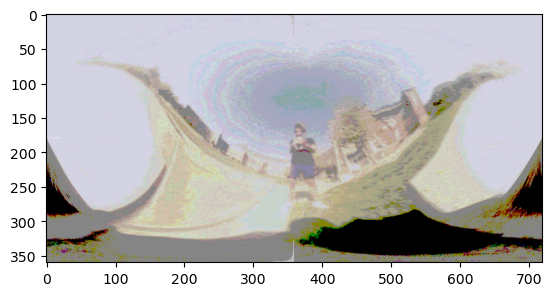

In [585]:
hdr_mirrorball_image = read_hdr_image('images/outputs/calib_hdr.hdr')
equi_rectangular_image = panoramic_transform(hdr_mirrorball_image)

write_hdr_image(equi_rectangular_image, 'images/outputs/equirectangular.hdr')

plt.figure(figsize=(15, 15))
display_hdr_image(equi_rectangular_image)

---

## Rendering synthetic objects into photographs 

Use Blender to render the scene with and with objects and obtain the mask image.  The code below should then load the images and create the final composite.

In [586]:
# Read the images that you produced using Blender.  Modify names as needed.
O = read_image('images/proj4_objects.png')
E = read_image('images/proj4_empty.png')
M = read_image('images/proj4_mask.png')
M = M > 0.5
I = background_image
I = cv2.resize(I, (M.shape[1], M.shape[0]))

[ WARN:0@115386.901] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('images/proj4_objects.png'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable

TypeError: Invalid shape (0,) for image data

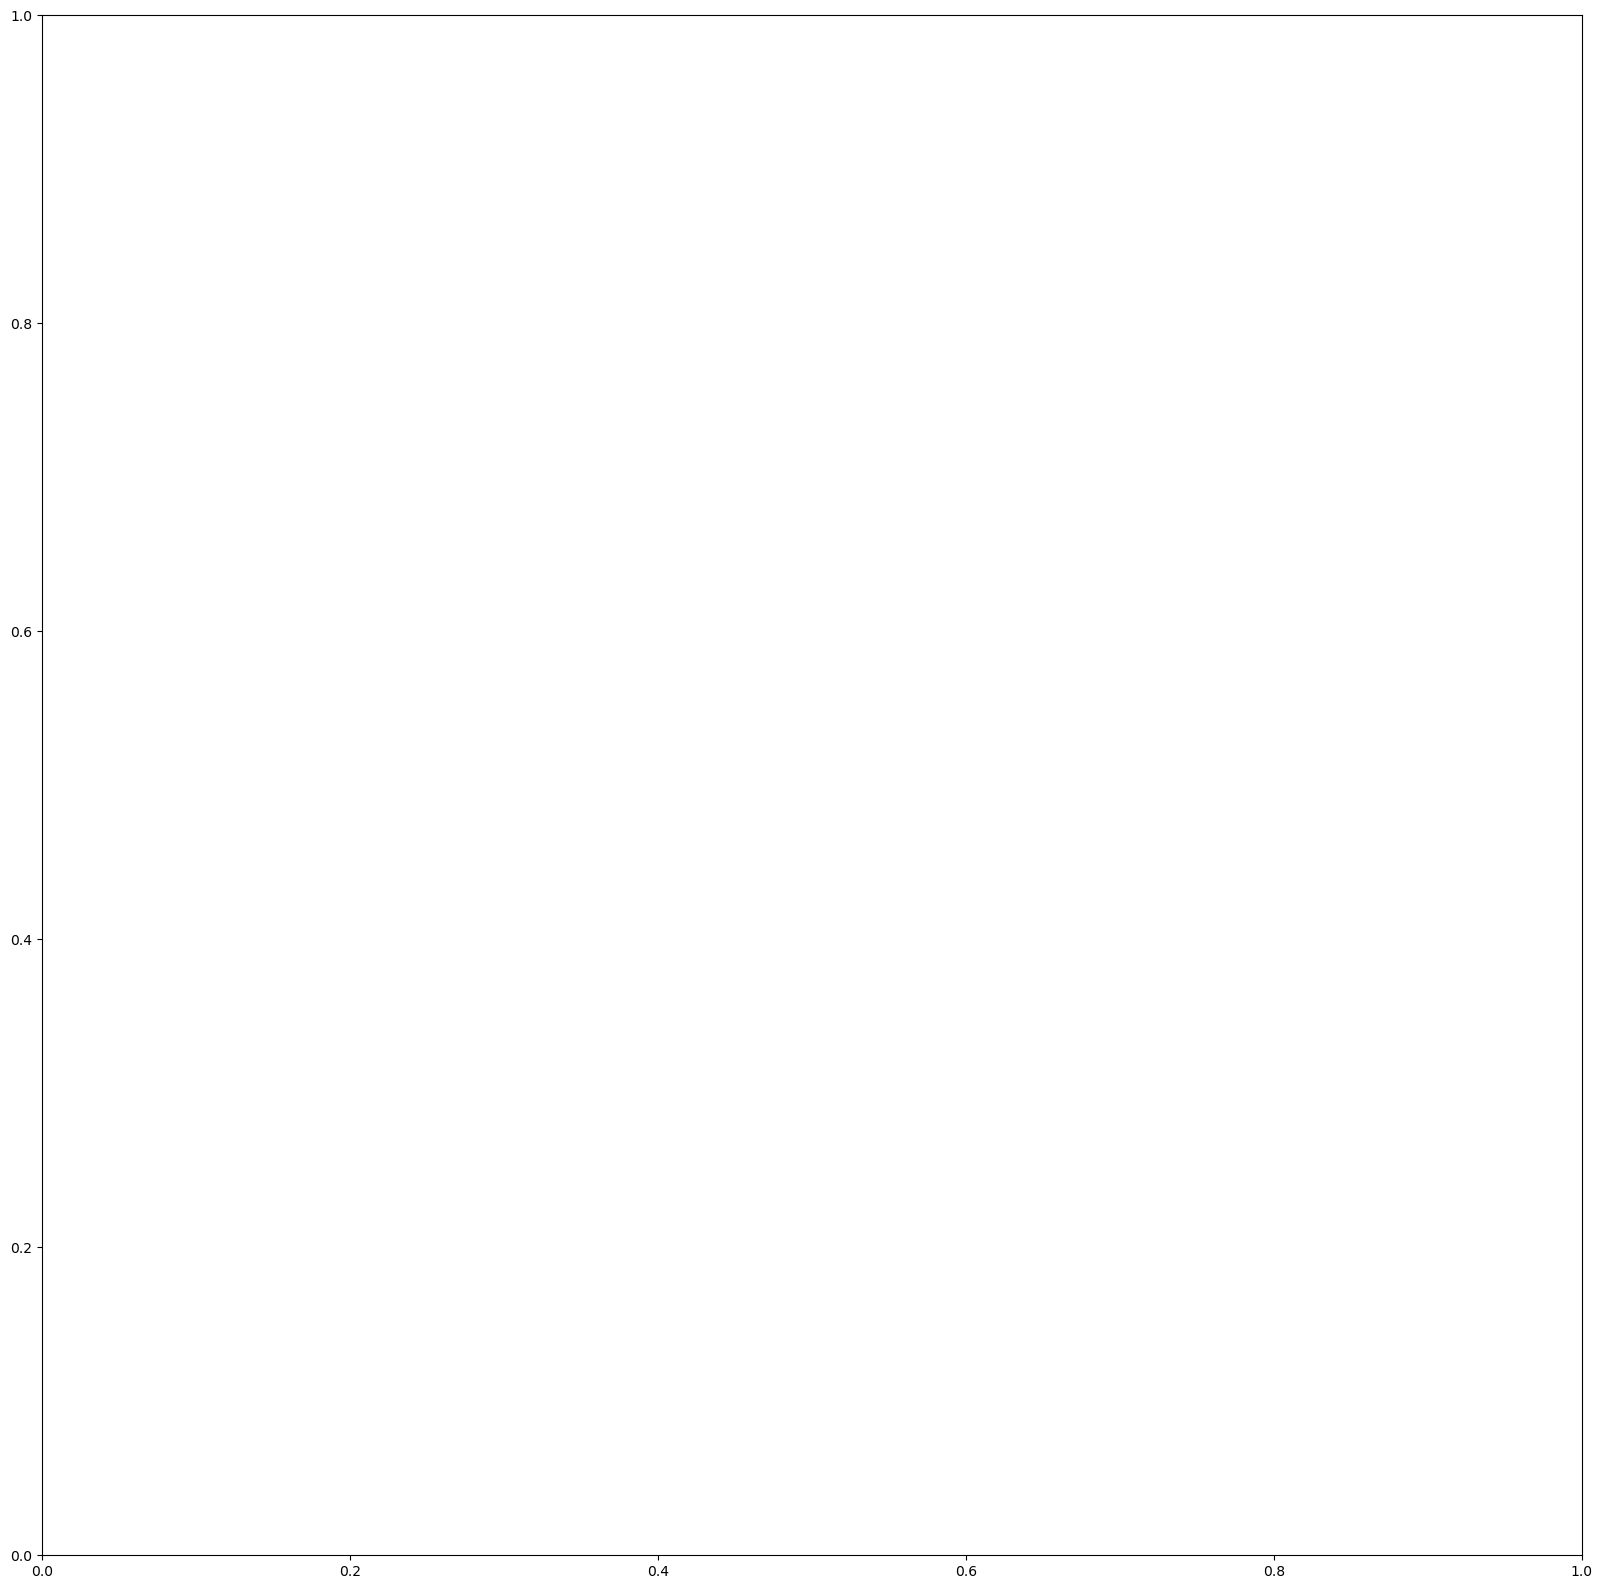

In [587]:
# TO DO: compute final composite
result = []

plt.figure(figsize=(20,20))
plt.imshow(result)
plt.show()

write_image(result, 'images/outputs/final_composite.png')

---


## Bells & Whistles (Extra Points)

### Additional Image-Based Lighting Result 


### Other panoramic transformations 


### Photographer/tripod removal 


### Local tonemapping operator 



In [588]:
def local_tonemapping(hdr_image, spatial_sigma, range_sigma, alpha):
    """
    Apply local tonemapping to an HDR image.

    Parameters:
    - hdr_image: Input HDR image (numpy array).
    - spatial_sigma: Spatial standard deviation for bilateral filter.
    - range_sigma: Range standard deviation for bilateral filter.
    - alpha: Controls the strength of the tonemapping effect.

    Returns:
    - ldr_image: Output LDR image after local tonemapping.
    """
    # Ensure the input HDR image is in the correct format
    hdr_image = hdr_image.astype(np.float32)

    # Perform bilateral filtering
    bilateral_filtered = bilateral_filter(hdr_image, spatial_sigma, range_sigma)

    # Calculate the detail layer
    detail_layer = hdr_image - bilateral_filtered

    # Apply tonemapping to the detail layer
    tonemapped_detail = alpha * detail_layer

    # Combine the tonemapped detail with the original HDR image
    ldr_image = bilateral_filtered + tonemapped_detail

    # Clip values to ensure they are within the valid range
    ldr_image = np.clip(ldr_image, 0, 1)

    return ldr_image


def bilateral_filter(image, spatial_sigma, range_sigma):
    """
    Apply bilateral filter to an image.

    Parameters:
    - image: Input image (numpy array).
    - spatial_sigma: Spatial standard deviation for the filter.
    - range_sigma: Range standard deviation for the filter.

    Returns:
    - filtered_image: Output image after bilateral filtering.
    """
    filtered_image = cv2.bilateralFilter(image, d=0, sigmaColor=range_sigma, sigmaSpace=spatial_sigma)
    return filtered_image

In [589]:
# Assuming hdr_image is your HDR image
spatial_sigma = 5
range_sigma = 0.1
alpha = 0.5

ldr_image = local_tonemapping(hdr_image, spatial_sigma, range_sigma, alpha)

# Plot the original HDR image
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(hdr_image)
plt.title('Original HDR Image')

# Plot the result of local tonemapping
plt.subplot(132)
plt.imshow(ldr_image_local)
plt.title('Local Tonemapping Result')

# You can add more subplots for other tonemapping methods

plt.show()

NameError: name 'hdr_image' is not defined